# Solutions 04

**Due:** 2022-03-10, 11:59 PM, as a Jupyter notebook (with related files) submitted via your repo in the course GitHub organization.  Edit the provided Solutions04 notebook with your solutions.

<div class="total">
Total score: 11.5/13.0
</div>

<div class="grader">
Grader: Georgia
</div>

***NOTE:*** *THIS IS A GRADED ASSIGNMENT NOTEBOOK.*  Graded notebooks use styling that is not rendered on GitHub or when first launching a saved notebook in a Jupyter server.  To properly view the graded notebook, please do one of the following:
* Open this notebook in a Jupyter server and run the entire notebook (Kernel -> Restart & Run All). (It may be sufficient simply to run the following code cell.)
* View the HTML version of the graded notebook in a web browser (do this with the version pulled to your computer; GitHub does not render HTML files stored in repos).

In [1]:
from IPython.display import HTML
HTML(open('graded_style.html', 'r').read())

## 0. Add/commit a .gitignore file in your assignments repo

Python, Jupyter, and other tools we'll use in the future create auxilliary files that are useful for running scripts, modules, and notebooks locally, but that should not be tracked and shared in your repo. Git supports the use of a `.gitignore` file at the top level of a repo, identifying files or groups of files (and folders) that should be ignored by Git. This file can also be used to make Git ignore platform-specific files that aren't useful to share, like the `.DS_Store` file that the macOS Finder creates in many folders (to hold file metadata).

We are providing a `.gitignore` file to use in your assignment repo. **Correctly adding and commiting the `.gitignore` file is required.** You will *lose 0.5 point if it is not done correctly*. Fortunately, it's easy to do:

* Sync your copy of our LabResources folder using `git pull` (which you probably already did to get your copy of this assignment).
* **Copy** (do not just move) the `dot-gitignore` file to the top level of your assignments repor. For me, I would put it inside my `tjl9-BDAOrg` folder, so its path would be `.../tjl9-BDAOrg/dot-gitignore'.
* **Rename** the file to `.gitignore`. On many platforms, this will cause the file to disappear from file listings (e.g., it will vanish in a macOS Finder window, and it will not appear in a Linus `ls` file listing). Don't worry, it's still there. The leading dot makes `.gitignore` a hidden file on many platforms.
* Use Git to add and commit the `.gitignore` file.

That's it!

If you use a tool (editor, IDE) that creates auxilliary files or folders in your repo that you don't want to track, feel free to **add** entries to the `.gitignore` file, directing Git not to track those files. But please do not remove entries from it.

## 1. Enhancing the *UnivariateBayesianInference* class

The assignment directory includes a `univariate_bayes.py` file that implements a `univariate_bayes` module with a single class, `UnivariateBayesianInference`; this code was introduced in Lab06.  This class is meant to be used as a **base class** that is inherited by a subclass written to solve univariate inference problems with a specific type of likelihood function and data.  Lab06 provided examples for binomial and Poisson cases.  For this problem, you will enhance the capabilities of `UnivariateBayesianInference`.

Your repo also has a `binomial_poisson.py` file, also meant to be used as module, with two classes that subclass `UnivariateBayesianInference`:  `BinomialInference` and `PoissonRateInference`.  We discussed and used these classes in Lab06.  There we created instances of those classes in the same file that defined them; here, you'll import the classes from the module and work with them in your solutions notebook.

### Problem 1.1 (2 points):

> Add code to the `__init__` method of the `UnivariateBayesianInference` class (defined in `univariate_bayes.py`) that computes the mean and standard deviation of the parameter's posterior PDF.  Store the results in two new data attributes:
* `mean`, containing the posterior mean of the value of the parameter by quadrature
* `std`, containing the posterior standard deviation by quadrature

> You may use quadrature functions in `NumPy` or `SciPy`. Be sure to maintain comments and docstrings:  revise the module docstring to note that you have revised the module's code, and provide brief comments for the added code.

In [2]:
"""
Module defining a base class implementing simple Bayesian inference for a
univariate model, using quadrature for integration.

Created Feb 27, 2015 by Tom Loredo
2018-03-08 Modified for Py-3, updated for BDA18
2020-02-26 Updated for BDA20
2022-03-10 Revised by Yi Han for BDA22 HW4
"""

import numpy as np
from numpy import *
from matplotlib.pyplot import plot


class UnivariateBayesianInference(object):
    """
    Implement Bayesian inference for a univariate model, using quadrature for
    integrals.
    """

    def __init__(self, param_grid, prior, lfunc=None, logprob=False):
        """
        Calculate the posterior distribution over a grid in parameter space.

        Either the likelihood or the log-likelihood may be specified.

        Parameters
        ----------
        param_grid : float array
            Array of parameter values; assumed equally spaced

        prior : float or function
            Prior PDF for the param, as a constant for flat prior, or
            a function that can evaluate the PDF on an array; if
            logprob == True, prior is interpreted as the log density

        lfunc : function
            Function that can evaluate the likelihood on an array; if
            logprob == True, lfunc is interpreted as the log likelihood

        logprob : boolean
            If False, prior and lfunc are interpreted as providing the actual
            prioir PDF and likelihood function; if True, they are interpreted
            as providing the log prior PDF and log likelihood function
        """
        self.param_grid = param_grid
        self.delta = param_grid[1] - param_grid[0]
        self.logprob = logprob

        # Evaluate prior and likelihood over the grid.  These will be
        # the log values if logprob=True.
        if callable(prior):
            self.prior_pdf = prior(param_grid)
        else:
            self.prior_pdf = prior * ones_like(param_grid)
        self.like = lfunc(param_grid)

        # Handle the logprob=True case.
        if self.logprob:
            # Subtract off the max to avoid possible underflow everywhere.
            # Note this affects the marginal likelihood so it needs to be
            # taken into account if the marginal likelihood is used directly,
            # e.g., to compute a Bayes factor.  So save the max values.
            self.max_log_prior = self.prior_pdf.max()
            self.prior_pdf = exp(self.prior_pdf - self.max_log_prior)
            self.max_log_like = self.like.max()
            self.like = exp(self.like - self.max_log_like)

        # Bayes's theorem, using the trapezoid rule for the marginal likeilhood:
        numer = self.prior_pdf * self.like
        self.mlike = np.trapz(numer, dx=self.delta)
        self.post_pdf = numer / self.mlike
        
        mean0=self.param_grid*self.post_pdf
        self.mean=np.trapz(mean0, dx=self.delta)
        std0=(self.param_grid-self.mean)*(self.param_grid-self.mean)
        std0=std0*self.post_pdf
        self.std=np.trapz(std0, dx=self.delta)

    def plot(self, ls='b-', lw=3, **kwds):
        """
        Plot the posterior PDF using the current axes.
        """
        plot(self.param_grid, self.post_pdf, ls, lw=lw, **kwds)



<div class="comments">
Grader comments
</div>



<div class="grade">
Problem 1.1 points:  2/2
</div>

### Problem 1.2 (2 points):

> Test the methods by creating one instance each of `PoissonRateInference` and `BinomialInference` in your solution notebook (with input arguments of your choosing) and comparing your quadrature-based mean and standard deviation posterior summaries with analytical formulas presented in lectures.  Do the comparison by calculating the percentage difference between the quadrature-based and formula-based results and displaying the the results and percentage differences in the notebook. Display the results with an appropriate level of precision (e.g., 2 or 3 significant digits), using Python's string formatting capability.  (See [Python String Format Cookbook – mkaz.blog](https://mkaz.blog/code/python-string-format-cookbook/) for tips on this.)

In [3]:
# the instance of PoissonRateInference

from binomial_poisson import PoissonRateInference
from scipy import stats, special, integrate

r_u = 20. 
r_l=0
prior_l, prior_u = 0., 1e5
flat_pdf = 1. / (prior_u - prior_l)
n, T = 16, 2
pri1 = PoissonRateInference(T, n, flat_pdf,r_l, r_u)
anly_mean=(n+1)/T
pct_diff=round(abs(pri1.mean-anly_mean)*100/anly_mean,3)
print('quadrature-based:',pri1.mean)
print('formula-based:',anly_mean)
print('percentage differences:',pct_diff,'%')

quadrature-based: 8.499825391761025
formula-based: 8.5
percentage differences: 0.002 %


In [4]:
# the instance of BionomialRateInference

from binomial_poisson import BinomialInference

n, n_trials = 80, 120

bi1 = BinomialInference(n, n_trials)
anly_mean=n/n_trials
pct_diff=round(abs(bi1.mean-anly_mean)*100/anly_mean,3)
print('quadrature-based:',bi1.mean)
print('formula-based:',anly_mean)
print('percentage differences:',pct_diff,'%')

quadrature-based: 0.663934426229508
formula-based: 0.6666666666666666
percentage differences: 0.41 %


<div class="comments">
Need to do comparison for std as well. Also, correct formula for binomial mean can be found in Lecture 5 (also shown in next cell).
</div>



<div class="grade">
Problem 1.2 points:  1/2
</div>

In [5]:
(n+1)/(n_trials+2)

0.6639344262295082

## 2. Inference with the Cauchy distribution

In Lab06 and Problem 1 the `UnivariateBayesianInference` base class was used to numerically compute results for inferences that we can handle analytically.  But this base class can also be used for problems that are not analytically tractable.  In this problem, you'll use it to do inference with data modeled with a **Cauchy distribution**.

The Cauchy distribution is a special case of the Student's $t$ distribution covered in Lec08; it corresponds to Student's $t$ with degrees of freedom parameter $\nu=1$. It has an undefined mean and an infinite variance.  It is troublesome to work with in frequentist statistics.  Even it's maximum likelihood estimator has complicated sampling properties that pose not just computational challenges, but conceptual ones (the best frequentist methods require adopting something called the *conditional frequentist approach*, related to the likelihood principle).  In Bayesian inference, it poses no conceptual difficulties, but it must be handled numerically—which you'll do here.

The Cauchy distribution is known in physics as the *Lorentzian distribution*, where in certain circumstances it describes the profile of spectral lines, and the distribution of particle mass peaks in accelerator experiments.  It also appears in problems where the ratio of two quantities with normal errors is of interest; when the quantities are uncorrelated with zero mean, the PDF for the ratio is a Cauchy distribution.  As noted above, the Student's $t$ distribution with 1 degree of freedom is a Cauchy distribution.  It also arises in geometric inference problems, as you will see in this problem.

You can find basic information about the Cauchy distribution [on Wikipedia](http://en.wikipedia.org/wiki/Cauchy_distribution) and in the [NIST Engineering Statistics Handbook](http://www.itl.nist.gov/div898/handbook/eda/section3/eda3663.htm).

### Problem 2.1 (2 points):

A rod of radioactive material is a distance $d$ behind a barrier (e.g., this could be a fuel rod inside a nuclear reactor). A narrow sensor strip is on the barrier, oriented orthogonal to the rod (and not near either of its ends). The rod is at an unknown position, $x_0$, along the sensor.  The sensor records the locations of $N$ gamma rays emitted by the rod, denoted $x_i$ (for $i=1$ to $N$).  We'll assume that $d$ is small compared to the length of the sensor, so that the sensor may be considered essentially infinite in length.

The geometry is shown in the following figure, oriented looking down along the rod (shown as a large dot).

<img src="CauchyGeometry.png"/>

> Assume the rod emits gamma rays isotropically (i.e., with a uniform distribution in the angle $\theta$; consider only angles corresponding to detectable gamma rays).  Show that the PDF for the detected location of a single gamma ray, $x$, is a Cauchy distribution with location parameter $x_0$ and scale parameter $d$.

$$tan\theta=\frac{x-x_0}{d}\quad \theta=arctan(\frac{x-x_0}{d})$$
Therefore, we have $$\frac{d\theta}{dx}=\frac{d\theta}{d(x-x_0)}=\frac{d}{d^2+(x-x_0)^2}$$
Since angle 𝜃 is assumed uniformly distributed,
$$f(x)=f(\theta)\frac{d\theta}{dx} \propto \frac{1}{1+(\frac{x-x_0}{d}) ^2}$$
 
Thus,the PDF for the detected location of a single gamma ray, x, is a Cauchy distribution with location parameter x0 and scale parameter d.

<div class="comments">
$f(\theta) = \frac{1}{\pi}$. This comes from the fact that the rays are emitted with a uniform distribution in the angle $\theta$, and $\theta$ is between $-\frac{\pi}{2}$ and $\frac{\pi}{2}$. Using this, you can get an exact answer for $f(x)$.
</div>



<div class="grade">
Problem 2.1 points:  1.5/2
</div>

### Problem 2.2 (5 points):

Implement and demonstrate inference for the Cauchy location parameter, $x_0$ (using a uniform prior):

> * Create a Python module `cauchy.py` with a class `CauchyLocationInference` that implements inference for the location of Cauchy-distributed data with a *known* scale parameter.
* In the notebook, define a function with signature `cauchy_case(x0, d, N, plot=True)` that does the following:
    1. Use `scipy.stats.cauchy` to simulate a dataset of size `N` from a Cauchy distribution with location and scale `x0` and `d`.
    2. Create an instance of your `CauchyLocationInference` class for inferring `x0` with the simulated data.
    3. If the `plot` argument is True, plot the PDF for `x0`.
    4. If the `plot` argument is True, show the posterior mean for `x0` on the plot by computing the mean with the `mean()` method, evaluating the PDF at that value, and plotting a marker (e.g., a large dot or diamond) on the curve just plotted in step 3.
    5. Return 2 (scalar) values: the value of the posterior mean, and the mean value of the samples in the simulated dataset.
* Run the function 5 times, with the same arguments, to produce a single plot with 5 example posterior PDFs. Choose values for `x0` and `d` as you wish.  Use a small sample size (say, $N=5$).  Be sure to label all plot axes in this exercise, and feel free to adjust plot parameters (axis limits, line widths, etc.) to help communicate the results.

In [6]:
from scipy.stats import *
from cauchy import CauchyLocationInference
import numpy as np
import matplotlib.pyplot as plt

def cauchy_case(x0, d, N, plot=True):
    #task1
    data=cauchy.rvs(loc=x0, scale=d, size=N, random_state=None)
    #print(data)
    r_u = max(data)+10
    r_l=min(data)-10
    prior=1
    
    #task2
    ci0 = CauchyLocationInference(data, prior, r_l, r_u,d)
    mean=ci0.mean
    rvals=ci0.rvals
    postpdf=ci0.post_pdf
    
    #task3-4
    #evaluating the PDF at the posterior mean
    m_prior=1
    m_like=ci0.lfunc(mean)
    m_post=m_prior*m_like[0]/ci0.mlike
    #m_post=postpdf[np.argmin(abs(rvals-mean))]
    
    if plot==True:
        plt.plot(rvals,postpdf,lw=1)
        plt.xlabel(r'$x_0$')
        plt.ylabel('Posterior PDF')
        plt.title('Cauchy Location estimation')
        #plot a marker
        plt.scatter([mean],[m_post],c='r')
    #print('The posterior mean:',mean)
    #print('PDF at the posterior mean',m_post)
    #print('The mean value of the samples:',np.mean(data))
    
    #task5
    return mean,np.mean(data)

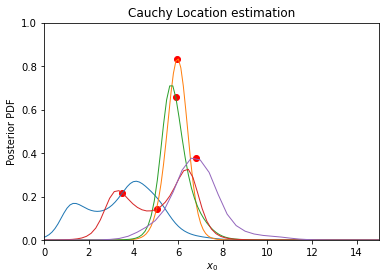

In [7]:
#Run the function 5 times with x0=6 d=1
for test in range(5):
    cauchy_case(6, 1, 5, plot=True)
    plt.axis([0, 15, 0, 1])

<div class="comments">
Grader comments
</div>



<div class="grade">
Problem 2.2 points:  5/5
</div>

### Problem 2.3 (2 points):

Means of one kind or another (e.g., arithmetic or weighted) are often used to estimate parameters from a sample of measurements modeled with IID sampling uncertainties.  The **central limit theorem** (CLT) provides a motivation for this.  It shows that, for large sample sizes $N$, and when the sampling distribution has a finite variance, the sample mean has a PDF that converges to a normal distribution with a standard deviation that, importantly, *shrinks with sample size* $\propto 1/\sqrt{N}$.

The Cauchy distribution does *not* have a finite variance; as a consequence, the CLT does not hold for the sample mean when the samples are from a Cauchy distribution.  Show this numerically:

> * Run your `cauchy_case` function many times (say, 1000, but use fewer for debugging!), with `plot=False`, collecting the posterior means and the sample means in separate arrays.  Use a largish sample size, say, $N=50$ or $100$.
* Use matplotlib's `hist` function to plot histograms of the posterior means and sample means.  Use its `normed` parameter to plot the histograms normalized as piecewise-constant PDFs.  You can use the `alpha` (opacity) argument to make regions of overlap easier to discern.  Feel free to change the number of bins from the default value.
* Plot the Cauchy PDF for a single observation as a solid curve on the same plot.
* Comment on what the plot reveals about the behavior of the sample mean.

In [8]:
post_mean=np.array([])
sample_mean=np.array([])

for i in range(0,1000):
    p,s=cauchy_case(6, 1, 80, plot=False)
    #collect the posterior means and the sample means in separate arrays
    post_mean=np.append(post_mean,p)
    sample_mean=np.append(sample_mean,s)

/Users/georgia/Desktop/CU-BDA-2022/classroom/yh726-BDAOrg/Assignment04/univariate_bayes.py:73: RuntimeWarning: invalid value encountered in true_divide
  self.post_pdf = numer / self.mlike


(array([3.21713427e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.21713427e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.21713427e-05, 0.00000000e+00, 3.21713427e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.21713427e-05, 3.21713427e-05,
        0.00000000e+00, 1.93028056e-04, 3.53884770e-04, 3.05627756e-02,
        6.11255512e-04, 1.28685371e-04, 0.00000000e+00, 0.00000000e+00,
        3.21713427e-05, 9.65140282e-05]),
 array([-1351.08588545, -1320.00232117, -1288.91875689, -1257.83519261,
        -1226.75162833

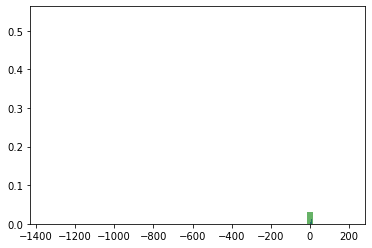

In [9]:
plt.hist(post_mean,bins=50,density=True,color='b',alpha=0.6)
plt.hist(sample_mean,bins=50,density=True,color='g',alpha=0.6)
#hard to discern when no range is set in the histogram

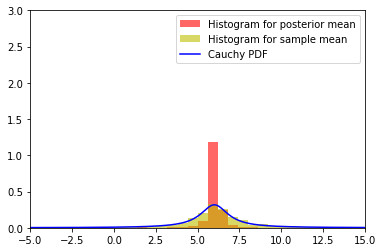

In [10]:
#set range of the plot to discern
plt.hist(post_mean,range=(-10,20),bins=50,density=True,color='r',alpha=0.6,label='Histogram for posterior mean')
plt.hist(sample_mean,range=(-10,20),bins=50,density=True,color='y',alpha=0.6,label='Histogram for sample mean')

#plot the Cauchy PDF for a single observation
x=np.linspace(-10,20,200)
y=cauchy.pdf(x, loc=6, scale=1)
plt.plot(x,y,color='blue',label='Cauchy PDF')

#set the axis by xmin=-5,xmax=15,ymin=0,ymax=3
plt.axis([-5, 15, 0, 3])
plt.legend()
plt.show()

> Comments:

According to CLT,for large sample sizes $N$, and when the sampling distribution has a finite variance, the sample mean has a PDF that converges to a normal distribution with a standard deviation that, importantly, *shrinks with sample size* $\propto 1/\sqrt{N}$.

But it is showm in the plot that the variance for one cauchy observation is close to sample means for 1000 observations, which clearly indicates that the standard deviation of sample means doesn't shrink with sample size. The CLT does not apply to the Cauchy distribution, so Cauchy distribution does not have a finite variance.

<div class="comments">
Grader comments
</div>



<div class="grade">
Problem 2.3 points:  2/2
</div>